# Benchmark creation with [Polaris](https://github.com/polaris-hub/polaris)
The first step of creating a benchmark is to set up a standard dataset which allows accessing the curated dataset (which has been demonstrated in <01_polaris_adme-fang-1_data_curation.ipynb>), and all necessary information about the dataset such as data source, description of endpoints, units etc. 

The resulting benchmarks can be found in Polaris:
- [biogen/adme-fang-hclint-1](https://polarishub.io/benchmarks/biogen/adme-fang-hclint-1)
- [biogen/adme-fang-rclint-1](https://polarishub.io/benchmarks/biogen/adme-fang-rclint-1)
- [biogen/adme-fang-perm-1](https://polarishub.io/benchmarks/biogen/adme-fang-perm-1)
- [biogen/adme-fang-hppb-1](https://polarishub.io/benchmarks/biogen/adme-fang-hppb-1)
- [biogen/adme-fang-rppb-1](https://polarishub.io/benchmarks/biogen/adme-fang-rppb-1)
- [biogen/adme-fang-solu-1](https://polarishub.io/benchmarks/biogen/adme-fang-solu-1)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib

import datamol as dm
import numpy as np

from sklearn.model_selection import ShuffleSplit

# polaris benchmark
from polaris.benchmark import (
    SingleTaskBenchmarkSpecification,
    MultiTaskBenchmarkSpecification,
)

# polaris hub
from polaris.cli import PolarisHubClient
from polaris.utils.types import HubOwner

# utils
root = pathlib.Path("__file__").absolute().parents[3]
os.chdir(root)
sys.path.insert(0, str(root))
from utils.docs_utils import load_readme

/Users/lu.zhu/miniconda3/envs/po_dataset/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get the owner and organization
org = "biogen"
data_name = "fang2023_ADME"
owner = HubOwner(slug=org, type="organization")
owner

HubOwner(slug='biogen', external_id=None, type='organization')

In [3]:
BENCHMARK_DIR = f"gs://polaris-public/{org}/{data_name}/benchmarks"
DATASET_JSON = (
    f"gs://polaris-public/{org}/{data_name}/datasets/adme-fang-1/dataset.json"
)
FIGURE_DIR = f"gs://polaris-public/{org}/{data_name}/figures"

## Load existing Dataset
> **Attention:** \
> See more dataset creataion details in [02_polaris_adme-fang_dataset.ipynb](https://github.com/polaris-hub/polaris-recipes/org-Biogen/fang2023_ADME/02_polaris_adme-fang_dataset.ipynb).

In [4]:
# Load the saved Dataset
from polaris.dataset import Dataset

dataset = Dataset.from_json(DATASET_JSON)

In [5]:
dataset

{
  "name": "adme-fang-1",
  "description": "A DMPK datasets of six ADME in vitro endpoints from fang et al. 2023. ",
  "tags": [
    "adme"
  ],
  "user_attributes": {},
  "owner": "biogen",
  "polaris_version": "dev",
  "default_adapters": {},
  "zarr_root_path": null,
  "md5sum": "acb647cbd9a9505ce3ad49a2c8f35e0c",
  "readme": "![ADME](https://storage.googleapis.com/polaris-public/icons/icon_fang.png) \n\n## Background\n\nThe goal of accessing ADME properties is to understand how a potential drug candidate interacts with the human body, including absorption, distribution, metabolism, and excretion. This knowledge is crucial for evaluating efficacy, safety, and clinical potential, guiding drug development for optimal therapeutic outcomes. [Fang et al. 2023](https://doi.org/10.1021/acs.jcim.3c00160) has disclosed DMPK datasets collected over 20 months across six ADME in vitro endpoints, which are human and rat liver microsomal stability, MDR1-MDCK efflux ratio, solubility, and human and rat plasma protein binding. The dataset contains 885 to 3087 measures for the corresponding endpoints. The compounds show the chemical diversity across all ranges of the endpoints which are microsomal stability, plasma protein binding, permeability, and solubility.\n\n## Description of readout\n- Microsomal stability (human and rat):  `LOG HLM_CLint (mL/min/kg)`, `LOG RLM_CLint (mL/min/kg)`\n- Plasma protein binding (human and rat): `LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)`, `LOG PLASMA PROTEIN BINDING (RAT) (% unbound)`\n- Permeability: `LOG MDR1-MDCK ER (B-A/A-B)`\n- Solubility: `LOG SOLUBILITY PH 6.8 (ug/mL)`\n- **Number of molecules after curation**: 3516\n\n## Data resource\n**Reference**: [Prospective Validation of Machine Learning Algorithms for Absorption, Distribution, Metabolism, and Excretion Prediction: An Industrial Perspective]( https://doi.org/10.1021/acs.jcim.3c00160)\n\n**Github**: https://github.com/molecularinformatics/Computational-ADME\n\n**Raw data**: https://github.com/molecularinformatics/Computational-ADME/blob/main/ADME_public_set_3521.csv \n\n## Data curation\nTo **maintain consistency** with other benchmarks in the Polaris Hub, a thorough data curation process is carried out to ensure the accuracy of molecular presentations.\n\nThe full curation and creation process is documented in [01_polaris_adme-fang-1_data_curation.ipynb](https://github.com/polaris-hub/polaris-recipes/org-Biogen/fang2023_ADME/01_polaris_adme-fang-1_data_curation.ipynb).\n",
  "annotations": {
    "UNIQUE_ID": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Molecular hash ID. See <datamol.mol.hash_mol>",
      "user_attributes": {},
      "dtype": "object"
    },
    "MOL_smiles": {
      "is_pointer": false,
      "modality": "MOLECULE",
      "description": "Molecule SMILES string after cleaning and standardization.",
      "user_attributes": {},
      "dtype": "object"
    },
    "SMILES": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Original molecule SMILES string from the publication.",
      "user_attributes": {},
      "dtype": "object"
    },
    "LOG_HLM_CLint": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Human liver microsomal stability reported as intrinsic clearance",
      "user_attributes": {
        "unit": "mL/min/kg",
        "scale": "log",
        "organism": "human",
        "objective": "Higher value"
      },
      "dtype": "float64"
    },
    "LOG_RLM_CLint": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Rat liver microsomal stability reported as intrinsic clearance",
      "user_attributes": {
        "unit": "mL/min/kg",
        "scale": "log",
        "organism": "rat",
        "objective": "Lower value"
      },
      "dtype": "float64"
    },
    "LOG_MDR1-MDCK_ER": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "MDR1-MDCK efflux ratio (B-A/A-B

## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test splits, and defining evaluation metrics to establish a baseline performance level.

### Create single task benchmarks from Fang2023 et al.
The tasks use the same test sets as in the Fang2023 paper. Here, we create a single task benchmark for each of the six ADME endpoints. The test set was created based on the train and test split provided in [this repository](https://github.com/molecularinformatics/Computational-ADME/tree/main/MPNN).

In [6]:
# Specify names and extract the test set from their dataset
endpoints = {
    "HLM": "HLM_CLint",
    "RLM": "RLM_CLint",
    "hPPB": "HPPB",
    "rPPB": "RPPB",
    "MDR1_ER": "MDR1-MDCK_ER",
    "Sol": "SOLUBILITY",
}

_endpoint = list(endpoints.keys())
INDIR = "gs://polaris-public/Data/ADME/fang2023/MPNN"

table = dataset.table

<div class="alert alert-block alert-warning"> <b>Attention:</b> We have noticed a set of molecules which have activity in MPNN folder, have no values in the `https://github.com/molecularinformatics/Computational-ADME/blob/main/ADME_public_set_3521.csv` file. We exclude the these molecules from splits to avoid confusion.</div>

In [7]:
split_key = "fang2023split"
paper_splits = {}
for endpoint in _endpoint:
    trainset = dm.read_csv(f"{INDIR}/ADME_{endpoint}_train.csv")
    testset = dm.read_csv(f"{INDIR}/ADME_{endpoint}_test.csv")
    train = table.query(
        f"`SMILES` in @trainset.smiles  & `{'LOG_'+endpoints[endpoint]}`.notna() "
    ).index.values
    test = table.query(
        f"`SMILES` in @testset.smiles  & `{'LOG_'+endpoints[endpoint]}`.notna() "
    ).index.values

    # check the intersections:
    intersection = set(train).intersection(set(test))
    if len(intersection) > 0:
        print(
            f"{endpoint} - Molecules {intersection} are in both training and test set"
        )
        # remove the molecules from trainig set
        train = np.array(list(set(train) - intersection))

    paper_splits[endpoints[endpoint]] = train, test

hPPB - Molecules {2689, 1417} are in both training and test set
rPPB - Molecules {2856, 1417, 473} are in both training and test set
MDR1_ER - Molecules {460} are in both training and test set


### Check distribution of train/test set in the chemical space

100%|██████████| 3521/3521 [00:07<00:00, 486.22it/s]


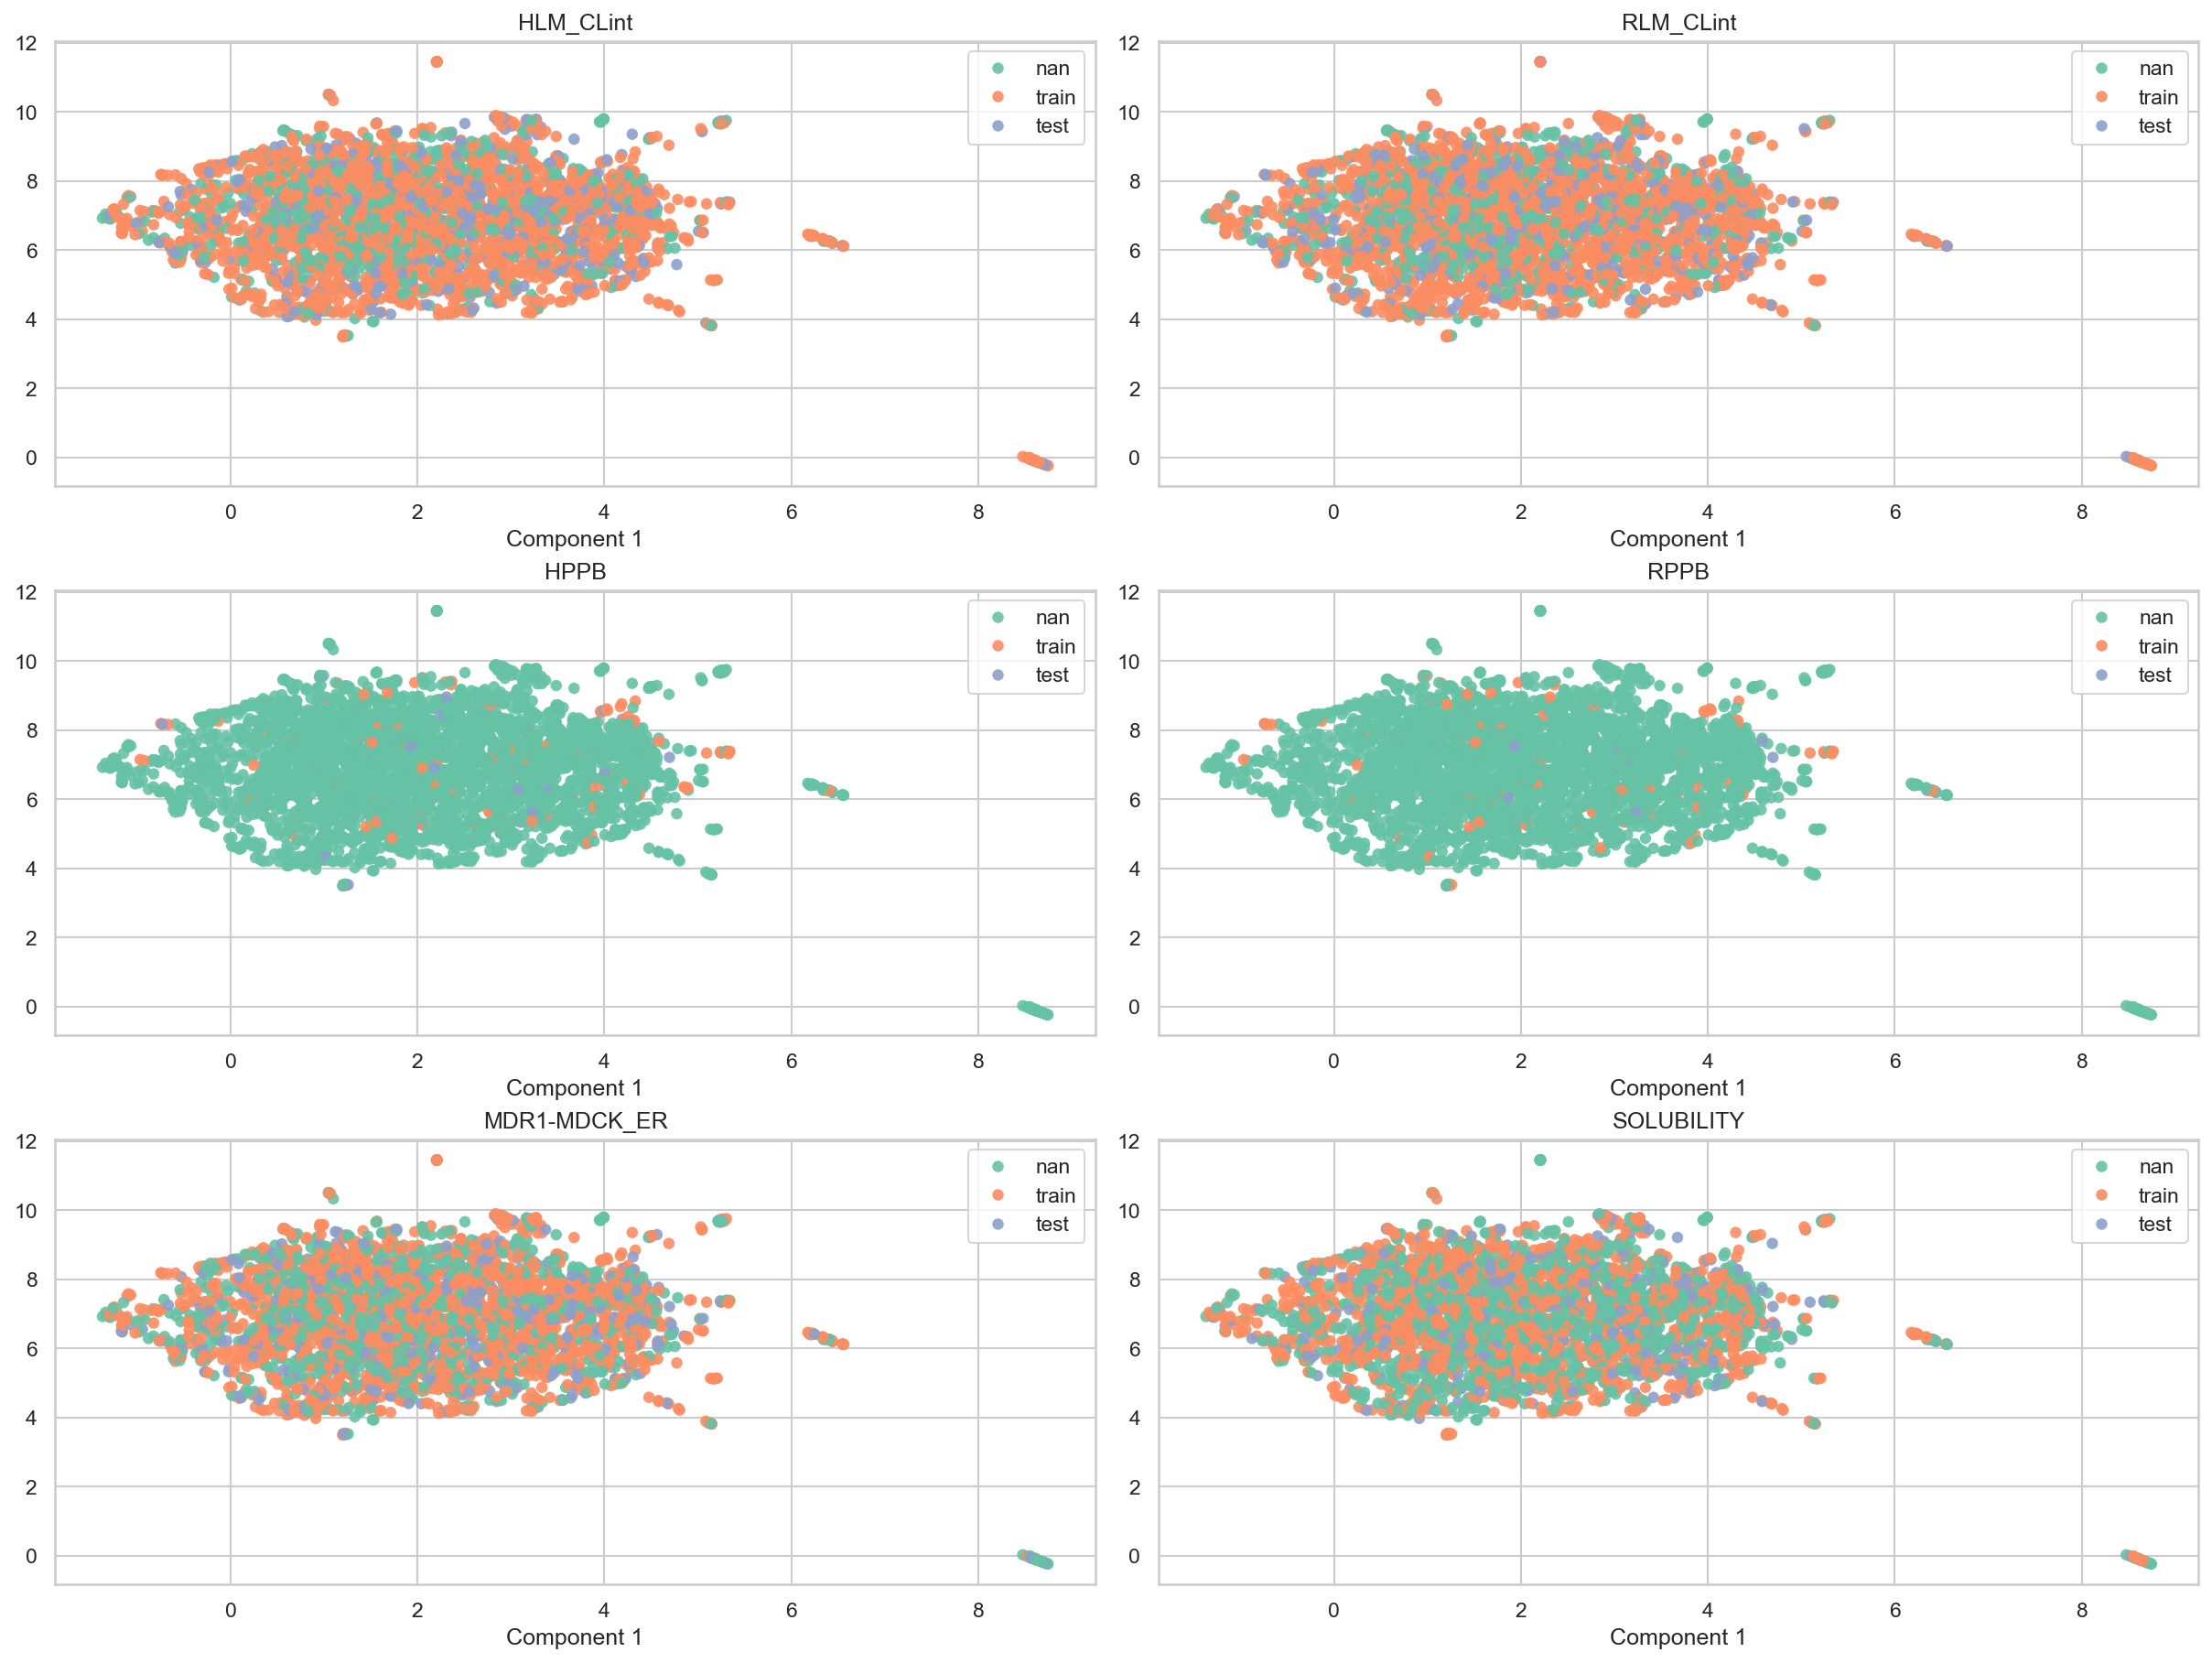

In [8]:
from utils.docs_utils import visualize_split_chemspace

mol_col = "MOL_smiles"

fig = visualize_split_chemspace(
    mols=table[mol_col].to_list(), train_test_dict=paper_splits
)

<div class="alert alert-block alert-warning"> <b>Attention:</b> The data points `nan` can not be found in `gs://polaris-public/Data/ADME/fang2023/MPNN` splitting files. </div>

In [9]:
# export the figure to remote path
from utils.auroris_utils import save_image

save_image(fig, dm.fs.join(FIGURE_DIR, f"{split_key}_chemspace.png"))

'https://storage.googleapis.com/polaris-public/biogen/fang2023_ADME/figures/fang2023split_chemspace.png'

## Create a benchmark for Fang et al. 2023 dataset
### The train/test sets are pre-defined from fang et al. 2023 

In [10]:
benchmark_version = "v1"

In [13]:
benchmark_path = {}
data_cols = [
    "LOG_HLM_CLint",
    "LOG_RLM_CLint",
    "LOG_MDR1-MDCK_ER",
    "LOG_HPPB",
    "LOG_RPPB",
    "LOG_SOLUBILITY",
]

split_key = "fang2023_split"

benchmark_names = [
    "adme-fang-HCLint",
    "adme-fang-RCLint",
    "adme-fang-PERM",
    "adme-fang-HPPB",
    "adme-fang-RPPB",
    "adme-fang-SOLU",
]

for target_col, benchmark_name in zip(data_cols, benchmark_names):
    benchmark_name = f"{benchmark_name}-{benchmark_version}"
    readme_name = f"fang2023_ADME_public_single_reg_{target_col}_v1"
    benchmark = SingleTaskBenchmarkSpecification(
        name=benchmark_name,
        dataset=dataset,
        target_cols=target_col,
        target_type="regression",
        input_cols=[mol_col],
        split=paper_splits[target_col[4:]],
        main_metric="pearsonr",  # fang et al. 2023 use the `pearsonr` for performance evalution
        metrics=[
            "mean_absolute_error",
            "mean_squared_error",
            "r2",
            "spearmanr",
            "pearsonr",
            "explained_var",
        ],
        tags=["adme", "singletask"],
        owner=owner,
        description=f"Single task benchmark for ADME property {target_col}",
        readme=load_readme(
            f"org-Biogen/fang2023_ADME/benchmarks/{readme_name}_readme.md"
        ),
    )
    BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
    path = benchmark.to_json(BENCHMARK_SAVE_DIR)
    print(path)

    # upload to polaris hub
    # client.upload_benchmark(benchmark=benchmark, access="private", owner=owner)

gs://polaris-public/biogen/fang2023_ADME/benchmarks/adme-fang-HCLint-v1/benchmark.json


2024-07-10 01:22:56.781 | SUCCESS  | polaris.hub.client:upload_benchmark:675 - Your benchmark has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/biogen/adme-fang-HCLint-v1


gs://polaris-public/biogen/fang2023_ADME/benchmarks/adme-fang-RCLint-v1/benchmark.json


2024-07-10 01:22:59.196 | SUCCESS  | polaris.hub.client:upload_benchmark:675 - Your benchmark has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/biogen/adme-fang-RCLint-v1


gs://polaris-public/biogen/fang2023_ADME/benchmarks/adme-fang-PERM-v1/benchmark.json


2024-07-10 01:23:01.616 | SUCCESS  | polaris.hub.client:upload_benchmark:675 - Your benchmark has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/biogen/adme-fang-PERM-v1


gs://polaris-public/biogen/fang2023_ADME/benchmarks/adme-fang-HPPB-v1/benchmark.json


2024-07-10 01:23:03.929 | SUCCESS  | polaris.hub.client:upload_benchmark:675 - Your benchmark has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/biogen/adme-fang-HPPB-v1


gs://polaris-public/biogen/fang2023_ADME/benchmarks/adme-fang-RPPB-v1/benchmark.json


2024-07-10 01:23:06.279 | SUCCESS  | polaris.hub.client:upload_benchmark:675 - Your benchmark has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/biogen/adme-fang-RPPB-v1


gs://polaris-public/biogen/fang2023_ADME/benchmarks/adme-fang-SOLU-v1/benchmark.json


2024-07-10 01:23:08.581 | SUCCESS  | polaris.hub.client:upload_benchmark:675 - Your benchmark has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/biogen/adme-fang-SOLU-v1


In [12]:
from polaris.hub.client import PolarisHubClient

client = PolarisHubClient()
client.login()

2024-07-10 01:22:13.350 | INFO     | polaris.hub.client:login:285 - You are already logged in to the Polaris Hub as  (lu@valencediscovery.com). Set `overwrite=True` to force re-authentication.
